In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# llm 설정
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini")

In [3]:
from langchain_community.tools import DuckDuckGoSearchRun

search = DuckDuckGoSearchRun()

In [4]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int) -> int:
    """Add two numbers together"""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers together"""
    return a * b

In [5]:
# vector store 생성
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    collection_name="real_estate_tax",
    persist_directory="./real_estate_tax_collection",
    embedding_function=embeddings
)

retriver = vector_store.as_retriever(search_kwargs={"k": 3})

In [6]:
from langchain_core.tools import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriver, 
    "real_estate_tax_retriever",
    "Real Estate Tax Retriever"
)

In [7]:
from langgraph.prebuilt import ToolNode

tool_list = [add, multiply, search, retriever_tool]

tool_node = ToolNode(tool_list)
llm_with_tools = llm.bind_tools(tool_list)

In [8]:
from langgraph.graph import MessagesState, StateGraph

class AgentState(MessagesState):
    summary: str

graph_builder = StateGraph(AgentState)

In [9]:
from langchain_core.messages import SystemMessage

def agent(state: AgentState):
    message = state['messages']
    summary = state['summary']

    if summary != '':
        message = [SystemMessage(content=f"Here is the summary of previous conversations: {summary}")] + message

    response = llm_with_tools.invoke(message)
    return {'messages': [response]}

In [10]:
def summarize_messages(state: AgentState):
    # state에서 메시지와 요약을 가져옵니다.
    messages = state['messages']
    summary = state['summary']
    
    # 요약 프롬프트를 생성합니다.
    summary_prompt = f'summarize this chat history below: \n\nchat_history:{messages}'
    
    # 기존 요약이 있으면, 요약을 포함한 프롬프트를 생성합니다.
    if summary != '':
        summary_prompt = f'''summarize this chat history below while looking at the summary of earlier conversations
chat_history:{messages}
summary:{summary}'''
    
    # LLM을 사용하여 요약을 생성합니다.
    summary = llm.invoke(summary_prompt)
    
    # 요약된 메시지를 반환합니다.
    return {'summary': summary.content}


In [11]:
from langchain_core.messages import RemoveMessage

def delete_message(state: MessagesState):
    current_message_list = state['messages']
    delete_message_list = [RemoveMessage(id=message.id) for message in current_message_list[:-3]]
    return {'messages': delete_message_list}

In [12]:
from typing import Literal

def should_continue(state: MessagesState) -> Literal['tools', 'summarize_messages']:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return 'tools'
    else:
        return 'summarize_messages'
        

In [13]:
graph_builder.add_node(agent)
graph_builder.add_node('tools', tool_node)
graph_builder.add_node(delete_message)
graph_builder.add_node(summarize_messages)

In [14]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent', 
    should_continue,{
        'tools': 'tools',
        'summarize_messages': 'summarize_messages'
    }
)
graph_builder.add_edge('tools', 'agent')
graph_builder.add_edge('summarize_messages', 'delete_message')
graph_builder.add_edge('delete_message', END)

In [15]:
from langgraph.checkpoint.memory import MemorySaver

checkpoint = MemorySaver()

graph = graph_builder.compile(
    checkpointer=checkpoint
)

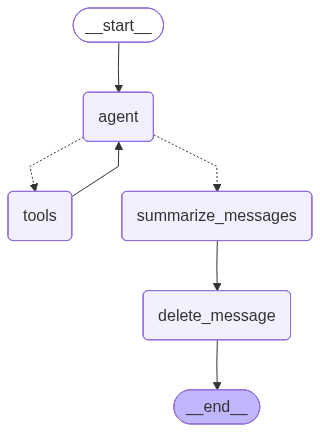

In [16]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [17]:
from langchain_core.messages import HumanMessage

config = {
    'configurable': {
        'thread_id': "real_estate_tax"
    }
}

messages = [HumanMessage(content="집이 15억일 때 종합부동산세를 계산해줄 수 있나요?")]

In [18]:
for chunk in graph.stream({'messages': messages, "summary": ""}, stream_mode='values', config=config):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

집이 15억일 때 종합부동산세를 계산해줄 수 있나요?
================================== Ai Message ==================================
Tool Calls:
  real_estate_tax_retriever (call_fxkrVKDwrdBf85Wh54Ikvvpv)
 Call ID: call_fxkrVKDwrdBf85Wh54Ikvvpv
  Args:
    query: 15억 종합부동산세
================================= Tool Message =================================
Name: real_estate_tax_retriever

| 45억원 초과 | 8천250만원+(45억원을 초과하는 금액의 1천분의 30) |
② 삭제<2008. 12. 26.>
③종합합산과세대상인 토지의 과세표준 금액에 대하여 해당 과세대상 토지의 토지분 재산세로 부과된 세액(「지방세법」 제111조제3항에 따라 가감조정된 세율이 적용된 경우에는 그 세율이 적용된 세액, 같은 법 제122조제1따라 세부담 상한률 적용받은 경우에는 그 상한률 적용받은 세액을 말한다)은 토지분 종합합산세액에서 이를 공제한다.
신설 2005. 12. 31, 2008. 12. 26, 2010. 3. 31.>
④별도합산과세대상인 토지에 대한 종합부동산세의 세액은 과세표준에 다음의 세율을 적용하여 계산한 금액(이하 “토지분 별도합산세액”이라 한다)으로 한다.<개정 2008. 12. 26.>
| 과세표준  | 세율  |
|---|---|
| 200억원 이하 | 1천분의 5 |
| 200억원 초과 400억원 이하 | 1억원+(200억원을 초과하는 금액의 1천분의 10) |
| 400억원 초과 | 2억원+(400억원을 초과하는 금액의 1천분의 12) |
⑤ 삭제<

In [19]:
current_message_list = graph.get_state(config).values['messages']
current_message_list

[AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 26, 'prompt_tokens': 171, 'total_tokens': 197, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-CUjrOnZefboaiEnqgodiPmgiclsTm', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--a2849103-35a1-44a9-aca6-7d6befaeb2b6-0', tool_calls=[{'name': 'real_estate_tax_retriever', 'args': {'query': '15억 종합부동산세'}, 'id': 'call_fxkrVKDwrdBf85Wh54Ikvvpv', 'type': 'tool_call'}], usage_metadata={'input_tokens': 171, 'output_tokens': 26, 'total_tokens': 197, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 ToolMessage

In [20]:
current_message_list = graph.get_state(config).values['summary']
current_message_list

'In the chat, a user inquires about calculating the comprehensive real estate tax for a house valued at 15 billion won. The AI responds with the applicable tax rates, explaining that for homes priced at 15 billion won, the tax rate is 0.1%. Consequently, the calculation yields a tax of 1.5 million won. The conversation includes detailed tax guidelines and legal references regarding the comprehensive real estate tax before concluding with the confirmed tax amount based on the provided house value.'

In [21]:
# from langchain_core.messages import RemoveMessage

# for index, message in enumerate(current_message_list):
#     if index < len(current_message_list) - 1:
#         graph.update_state(config, {'messages' : RemoveMessage(id=message.id)})

In [22]:
# current_message_list = graph.get_state(config).values['messages']
# current_message_list

In [ ]:
question = "엥??? 나 건물 1개인데??"
for chunk in graph.stream({'messages': HumanMessage(content=question)}, stream_mode='values', config=config):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

엥??? 나 건물 1개인데??


In [ ]:
messages = graph.get_state(config).values['messages']
summary = graph.get_state(config).values['summary']
print(messages)
print(summary)

In [24]:
# question = "어디서는 1340만원이라는데?? 어떻게 된거야?"
# for chunk in graph.stream({'messages': HumanMessage(content=question)}, stream_mode='values', config=config):
#     chunk['messages'][-1].pretty_print()